# Building Langgraph Image

In [2]:
from backend import Preprocessing
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Tuple
from langchain_core.documents import Document
from IPython.display import display, Markdown

class RAGState(TypedDict):
    query: str
    reformulations: List[str]
    all_queries: List[str]
    query_embeddings: List  # list of numpy arrays
    retrieved_docs: List[Document]
    chat_history: List[Tuple[str, str]]
    answer: str

processor = Preprocessing()

def generate_reformulations(state: RAGState) -> RAGState:
    reformulations = processor.generate_query_reformulations(state["query"])
    return {
        **state,
        "reformulations": reformulations,
        "all_queries": [state["query"]] + reformulations
    }

def embed_all_queries(state: RAGState) -> RAGState:
    embeddings = [processor.embed_query(q) for q in state["all_queries"]]
    return {
        **state,
        "query_embeddings": embeddings
    }

def retrieve_docs(state: RAGState) -> RAGState:
    file_path = "chunked_world_cup_data_final1.csv"
    embeddings_file = "worldcup_embeddings.npy"
    docs = processor.load_csv_documents(file_path)
    doc_embeddings = processor.create_document_embeddings(docs, embeddings_file)
    retrieved_docs = processor.rag_fusion_retrieval(state["query"], docs, doc_embeddings)
    return {
        **state,
        "retrieved_docs": retrieved_docs
    }

def answer_question(state: RAGState) -> RAGState:
    answer = processor.ask_groq_chatbot(state["query"], state["retrieved_docs"], state["chat_history"])
    return {
        **state,
        "answer": answer
    }

def update_chat(state: RAGState) -> RAGState:
    updated_history = state["chat_history"] + [(state["query"], state["answer"])]
    return {
        **state,
        "chat_history": updated_history
    }

# === Build and Visualize LangGraph ===
graph = StateGraph(RAGState)
graph.add_node("Generate Reformulations", generate_reformulations)
graph.add_node("Embed Queries", embed_all_queries)
graph.add_node("Retrieve Docs", retrieve_docs)
graph.add_node("Answer Question", answer_question)
graph.add_node("Update History", update_chat)

graph.set_entry_point("Generate Reformulations")
graph.add_edge("Generate Reformulations", "Embed Queries")
graph.add_edge("Embed Queries", "Retrieve Docs")
graph.add_edge("Retrieve Docs", "Answer Question")
graph.add_edge("Answer Question", "Update History")
graph.add_edge("Update History", END)

# Render the graph using Mermaid syntax

# mermaid_code = graph.draw_mermaid_png()
# display(Markdown(f"```mermaid\n{mermaid_code}\n```"))
graph = graph.compile()

c:\Users\aguda\OneDrive\Desktop\World Cup Rag Chat Bot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


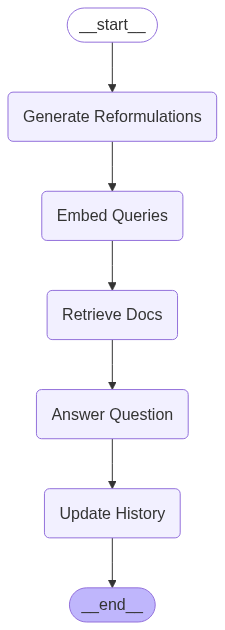

In [3]:
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass